In [7]:
import networkx as nx
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict


class MaxConcurrentFlowSolver:
    """
    Solver for maximum concurrent flow problems in undirected networks.
    Finds the maximum flow that all sessions can achieve simultaneously.
    """
    
    def __init__(self, G: nx.Graph, sessions: List[Tuple[int, int]]):
        """
        Initialize the solver with a network and sessions.
        
        Args:
            G: NetworkX undirected graph with edge capacities stored as 'capacity' attribute
            sessions: List of (source, target) tuples representing commodity flows
        """
        self.G = G.copy()
        self.sessions = sessions
        self.num_nodes = G.number_of_nodes()
        self.num_edges = G.number_of_edges()
        self.num_commodities = len(sessions)
        
        # Store edges in a consistent order
        self.edges = list(G.edges())
        self.edge_index = {e: i for i, e in enumerate(self.edges)}
        
        # Add reverse edges to the edge index for undirected graph
        for (u, v) in list(self.edge_index.keys()):
            self.edge_index[(v, u)] = self.edge_index[(u, v)]
        
        # Extract edge capacities
        self.capacities = np.array([G[u][v].get('capacity', float('inf')) for u, v in self.edges])
        
        # Initialize results
        self.flows = None
        self.max_concurrent_flow = None
        self.status = None
    
    def solve(self):
        """
        Solve the maximum concurrent flow problem using linear programming.
        
        Returns:
            Dict containing solution status and optimal flows
        """
        # Create flow variables for each commodity on each edge
        # f[k][i][j] represents flow of commodity k on edge (i,j)
        f = {}
        for k in range(self.num_commodities):
            f[k] = {}
            for i in range(self.num_nodes):
                f[k][i] = {}
                for j in range(self.num_nodes):
                    if self.G.has_edge(i, j):
                        f[k][i][j] = cp.Variable(nonneg=True)
        
        # Create variable for the maximum concurrent flow
        # This represents how much flow each session can carry
        mcf = cp.Variable(nonneg=True)
        
        # Objective: Maximize the concurrent flow
        objective = cp.Maximize(mcf)
        
        # Constraints
        constraints = []
        
        # 1. Capacity constraints for each edge (sum of all commodity flows <= edge capacity)
        for u, v in self.edges:
            edge_flow_sum = 0
            for k in range(self.num_commodities):
                edge_flow_sum += f[k][u][v] + f[k][v][u]  # Sum both directions for undirected
            constraints.append(edge_flow_sum <= self.G[u][v].get('capacity', float('inf')))
        
        # 2. Flow conservation constraints
        for k, (source, target) in enumerate(self.sessions):
            for i in range(self.num_nodes):
                if i != source and i != target:  # For intermediate nodes
                    # Sum of incoming flows equals sum of outgoing flows
                    flow_balance = 0
                    for j in self.G.neighbors(i):
                        flow_balance += f[k][j][i] - f[k][i][j]
                    constraints.append(flow_balance == 0)
        
        # 3. Flow requirements - each session must achieve the mcf value
        for k, (source, target) in enumerate(self.sessions):
            # Calculate the net outflow at source
            source_outflow = 0
            for j in self.G.neighbors(source):
                source_outflow += f[k][source][j] - f[k][j][source]
            constraints.append(source_outflow == mcf)
            
            # The net inflow at target should equal the outflow at source
            target_inflow = 0
            for i in self.G.neighbors(target):
                target_inflow += f[k][i][target] - f[k][target][i]
            constraints.append(target_inflow == mcf)
        
        # Solve the problem
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.ECOS)
        
        # Store results
        self.status = problem.status
        self.max_concurrent_flow = mcf.value
        
        # Extract flow values for each commodity on each edge
        self.flows = {}
        for k in range(self.num_commodities):
            self.flows[k] = {}
            for u, v in self.edges:
                self.flows[k][(u, v)] = f[k][u][v].value
        
        return {
            'status': self.status,
            'max_concurrent_flow': self.max_concurrent_flow,
            'flows': self.flows
        }
    
    def get_flow_dict(self) -> Dict:
        """
        Returns a dictionary of flows for each session and edge.
        
        Returns:
            Dict: {session_idx: {(u, v): flow_value}}
        """
        if self.flows is None:
            raise ValueError("Problem must be solved before getting flows")
        return self.flows
    
    def visualize_network(self, figsize=(12, 8)):
        """
        Visualize the network with edge capacities and optimal flows.
        """
        if self.flows is None:
            raise ValueError("Problem must be solved before visualization")
        
        plt.figure(figsize=figsize)
        
        # Create position layout
        pos = nx.spring_layout(self.G, seed=42)
        
        # Draw nodes
        nx.draw_networkx_nodes(self.G, pos, node_size=500)
        
        # Draw edges with capacity labels
        edge_labels = {(u, v): f"cap: {self.G[u][v].get('capacity', '∞')}" for u, v in self.edges}
        nx.draw_networkx_edges(self.G, pos, width=1.0, alpha=0.5)
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels)
        
        # Draw node labels
        nx.draw_networkx_labels(self.G, pos)
        
        # Add source and target information
        for k, (source, target) in enumerate(self.sessions):
            plt.annotate(f"Session {k}: {source}→{target} (flow: {self.max_concurrent_flow:.4f})",
                        xy=(0, 0), xytext=(0, -30 - 10 * k),
                        xycoords=('axes fraction'), textcoords='offset points',
                        ha='left', va='top')
        
        plt.title(f"Maximum Concurrent Flow: {self.max_concurrent_flow:.4f}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def print_solution(self):
        """
        Print the solution details.
        """
        if self.flows is None:
            raise ValueError("Problem must be solved before printing solution")
        
        print(f"Solution status: {self.status}")
        print(f"Maximum concurrent flow: {self.max_concurrent_flow:.4f}")
        
        for k, (source, target) in enumerate(self.sessions):
            print(f"\nSession {k}: {source} → {target} (flow: {self.max_concurrent_flow:.4f})")
            
            # Find all paths with positive flow for this session
            paths = []
            visited = set()
            
            def find_paths(node, path, remaining_flow):
                if node == target and remaining_flow > 1e-6:
                    paths.append((path[:], remaining_flow))
                    return
                
                visited.add(node)
                for neighbor in self.G.neighbors(node):
                    edge = (node, neighbor)
                    flow = self.flows[k].get(edge, 0)
                    if flow > 1e-6 and neighbor not in visited:
                        path.append(neighbor)
                        find_paths(neighbor, path, min(remaining_flow, flow))
                        path.pop()
                visited.remove(node)
            
            # Start DFS from source
            find_paths(source, [source], float('inf'))
            
            # Print paths
            total_session_flow = 0
            for path, flow in paths:
                print(f"  Path: {' → '.join(map(str, path))}, Flow: {flow:.4f}")
                total_session_flow += flow
            
            print(f"  Total session flow: {total_session_flow:.4f}")
    
    def visualize_flows(self, figsize=(15, 10)):
        """
        Visualize the network with flows for each session.
        """
        if self.flows is None:
            raise ValueError("Problem must be solved before visualization")
        
        # Create a separate visualization for each session
        for k, (source, target) in enumerate(self.sessions):
            plt.figure(figsize=figsize)
            pos = nx.spring_layout(self.G, seed=42)
            
            # Create edge colors based on flow values for this session
            edge_colors = []
            edge_widths = []
            
            for u, v in self.edges:
                # Get the flow in both directions
                flow_uv = self.flows[k].get((u, v), 0)
                flow_vu = self.flows[k].get((v, u), 0)
                
                # Determine color intensity based on flow
                net_flow = max(flow_uv, flow_vu)
                edge_colors.append(net_flow)
                edge_widths.append(1 + 5 * net_flow / self.max_concurrent_flow if self.max_concurrent_flow > 0 else 1)
            
            # Draw the network
            nx.draw_networkx_nodes(self.G, pos, node_size=700,
                                  node_color=['red' if n == source else 'green' if n == target else 'lightblue' 
                                             for n in self.G.nodes()])
            
            # Draw edges with width proportional to flow
            edges = nx.draw_networkx_edges(self.G, pos, width=edge_widths, edge_color=edge_colors, 
                                         edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=self.max_concurrent_flow)
            
            # Add a colorbar
            sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(0, self.max_concurrent_flow))
            sm.set_array([])
            cbar = plt.colorbar(sm)
            cbar.set_label('Flow Amount')
            
            # Draw node labels
            nx.draw_networkx_labels(self.G, pos)
            
            # Set title
            plt.title(f"Session {k}: {source} → {target} (Flow: {self.max_concurrent_flow:.4f})")
            plt.axis('off')
            plt.tight_layout()
            plt.show()


# Example usage
def run_example():
    # Create a sample network
    G = nx.Graph()
    
    # Add nodes and edges with capacities
    edges = [
        (0, 3, 1),
        (0, 4, 1),
        (3, 1, 1),
        (1, 4, 1),
        (3, 2, 1),
        (2, 4, 1)
    ]
    for u, v, capacity in edges:
        G.add_edge(u, v, capacity=capacity)
    
    # Define sessions: (source, target)
    sessions = [
        (0, 2),  # Session 0: Send flow from node 0 to node 4
        (1, 0),
        (2,1),
        (3,4)   # Session 1: Send flow from node 1 to node 3
    ]
    
    # Create and solve the maximum concurrent flow problem
    solver = MaxConcurrentFlowSolver(G, sessions)
    result = solver.solve()
    
    # Display results
    solver.print_solution()
    # solver.visualize_network()
    # solver.visualize_flows()


if __name__ == "__main__":
    run_example()

Solution status: optimal
Maximum concurrent flow: 0.7500

Session 0: 0 → 2 (flow: 0.7500)
  Path: 0 → 3 → 2, Flow: 0.3750
  Path: 0 → 4 → 2, Flow: 0.3750
  Total session flow: 0.7500

Session 1: 1 → 0 (flow: 0.7500)
  Total session flow: 0.0000

Session 2: 2 → 1 (flow: 0.7500)
  Total session flow: 0.0000

Session 3: 3 → 4 (flow: 0.7500)
  Total session flow: 0.0000


Testing K3,2 cyclic network:
Optimal rate: 2.104796915100039e-11, Status: optimal


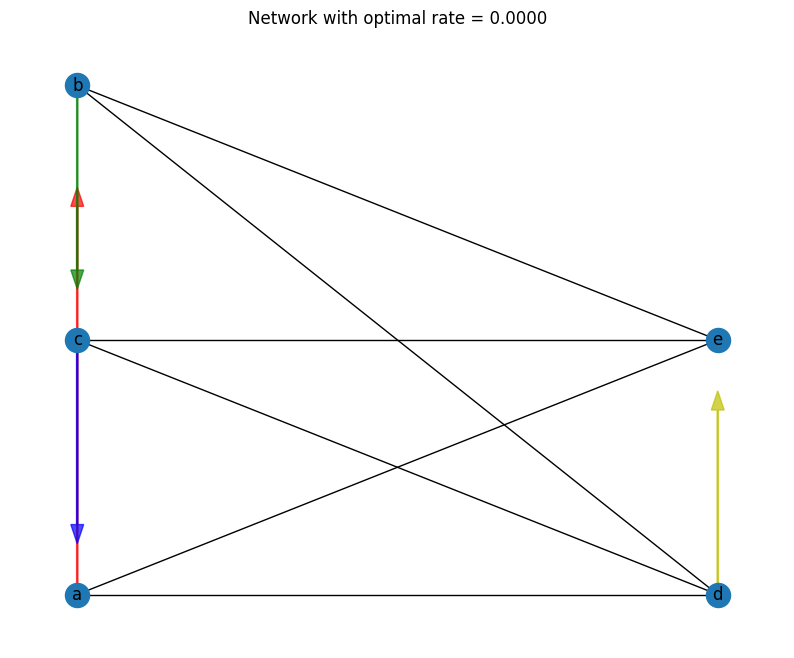


Testing K3,2 acyclic network:
Optimal rate: 4.7883675221765126e-12, Status: optimal


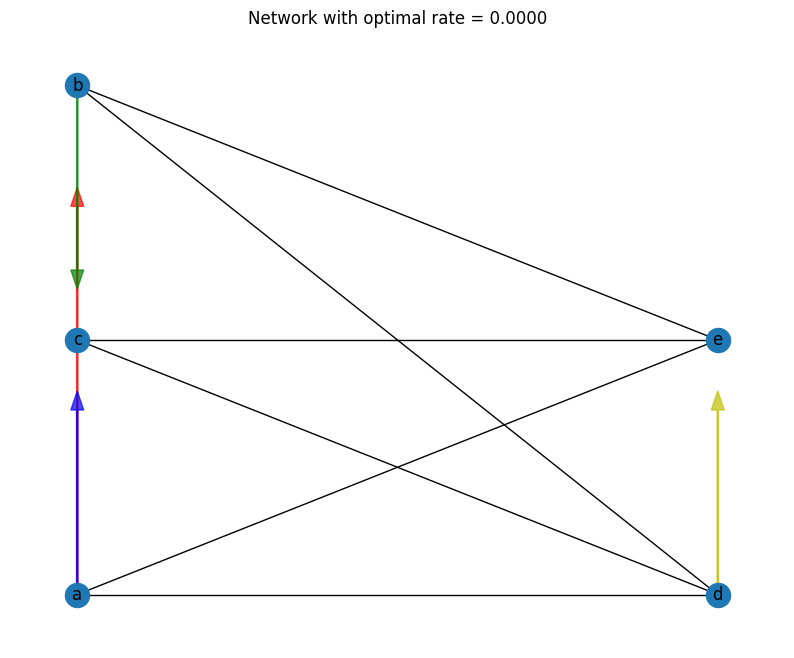

Random network with 6 nodes, 10 edges, 3 pairs
Optimal rate: 0.9999999999968986, Status: optimal


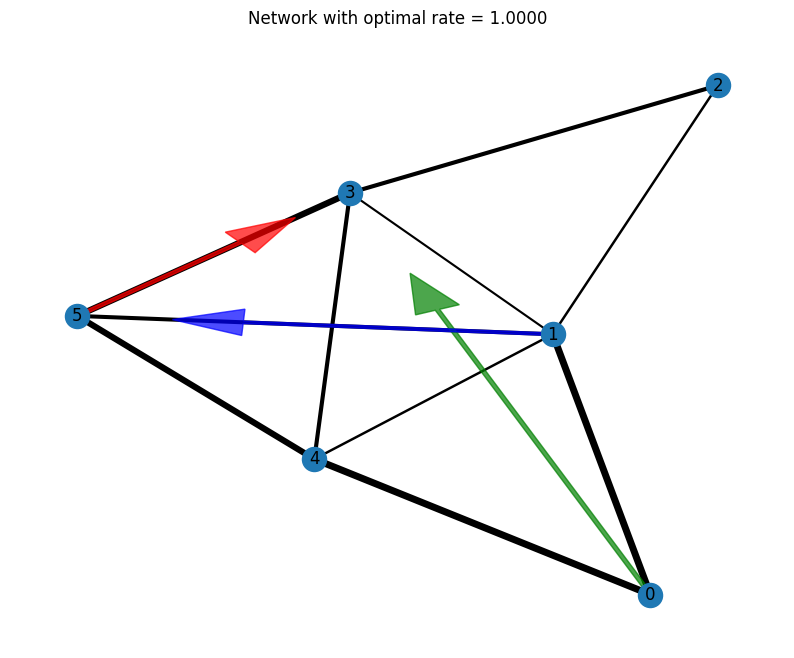

In [26]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def calculate_network_coding_rate(G, source_sink_pairs):
    """
    Calculate the optimal network coding rate for a multi-session unicast network
    using entropy-based constraints from the paper.
    
    Parameters:
    - G: networkx undirected graph with unit capacities
    - source_sink_pairs: list of (source, sink) pairs
    
    Returns:
    - optimal_rate: maximum achievable rate
    """
    # Create a directed version of the graph for edge variables
    directed_G = nx.DiGraph()
    for u, v in G.edges():
        directed_G.add_edge(u, v)
        directed_G.add_edge(v, u)
    
    # Get nodes and edges
    nodes = list(G.nodes())
    directed_edges = list(directed_G.edges())
    
    # Number of source-sink pairs
    k = len(source_sink_pairs)
    
    # Create entropy variables
    # Each entropy variable represents H(X_i)
    # We assume all source-sink pairs have the same rate r
    r = cp.Variable(nonneg=True)
    
    # Create entropy variables for each directed edge
    edge_entropies = {}
    for u, v in directed_edges:
        edge_entropies[(u, v)] = cp.Variable(nonneg=True)
    
    # Constraints
    constraints = []
    
    # All edges have capacity 1 in the undirected graph
    # For each edge (u,v) in the undirected graph, the sum of entropies
    # in both directions should be at most 1
    for u, v in G.edges():
        constraints.append(edge_entropies[(u, v)] + edge_entropies[(v, u)] <= 1)
    
    # Input-Output inequalities for each node
    for node in nodes:
        # Get incoming and outgoing edges
        in_edges = [(u, node) for u in G.neighbors(node)]
        out_edges = [(node, v) for v in G.neighbors(node)]
        
        # Get source-sink pairs where this node is a source or sink
        sources_at_node = [i for i, (s, _) in enumerate(source_sink_pairs) if s == node]
        sinks_at_node = [i for i, (_, t) in enumerate(source_sink_pairs) if t == node]
        
        # Input-Output inequality: information going out is a function of information coming in
        # For each node, sum of outgoing edge entropies <= sum of incoming edge entropies + source variables
        if out_edges:  # If node has outgoing edges
            outgoing_sum = sum(edge_entropies[e] for e in out_edges)
            if in_edges:  # If node has incoming edges
                incoming_sum = sum(edge_entropies[e] for e in in_edges)
                # Add source variables if any
                if sources_at_node:
                    incoming_sum += len(sources_at_node) * r
                constraints.append(outgoing_sum <= incoming_sum)
    
    # Crypto inequality for cuts 
    # For each pair of nodes, consider the cut that separates them
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            node_i = nodes[i]
            node_j = nodes[j]
            
            # Find source-sink pairs that are separated by this cut
            cut_set = {node_i}
            cut_complement = set(nodes) - cut_set
            
            if node_j in cut_complement:  # node_j is in the complement of the cut
                # Count source-sink pairs separated by the cut
                pairs_separated = []
                for idx, (s, t) in enumerate(source_sink_pairs):
                    if (s in cut_set and t in cut_complement) or (t in cut_set and s in cut_complement):
                        pairs_separated.append(idx)
                
                if pairs_separated:  # If any pairs are separated
                    # Edges crossing the cut
                    cut_edges = []
                    for u, v in directed_edges:
                        if (u in cut_set and v in cut_complement) or (v in cut_set and u in cut_complement):
                            cut_edges.append((u, v))
                    
                    # Crypto inequality: information across the cut is at least the information of separated pairs
                    if cut_edges:
                        cut_entropy = sum(edge_entropies[e] for e in cut_edges)
                        separated_entropy = len(pairs_separated) * r
                        constraints.append(cut_entropy >= separated_entropy)
    
    # Flow conservation constraints
    # For each source-sink pair, ensure flow from source to sink
    for idx, (source, sink) in enumerate(source_sink_pairs):
        # For each node except source and sink
        for node in nodes:
            if node != source and node != sink:
                # Sum of incoming flow = sum of outgoing flow
                in_flow = sum(edge_entropies[(u, node)] for u in G.neighbors(node))
                out_flow = sum(edge_entropies[(node, v)] for v in G.neighbors(node))
                constraints.append(in_flow == out_flow)
        
        # Source produces r units of flow
        source_out = sum(edge_entropies[(source, v)] for v in G.neighbors(source))
        if source in [t for _, t in source_sink_pairs]:  # If source is also a sink in some pair
            constraints.append(source_out >= r)
        else:
            constraints.append(source_out == r)
        
        # Sink consumes r units of flow
        sink_in = sum(edge_entropies[(u, sink)] for u in G.neighbors(sink))
        if sink in [s for s, _ in source_sink_pairs]:  # If sink is also a source in some pair
            constraints.append(sink_in >= r)
        else:
            constraints.append(sink_in == r)
    
    # Additional constraints from the paper
    # Specifically for bipartite graphs (like K3,2)
    if nx.is_bipartite(G):
        X, Y = nx.bipartite.sets(G)
        
        # Count source-sink pairs in different configurations
        n1 = sum(1 for s, t in source_sink_pairs if s in X and t in Y)  # X to Y
        n2 = sum(1 for s, t in source_sink_pairs if s in Y and t in X)  # Y to X
        n = sum(1 for s, t in source_sink_pairs if (s in X and t in X) or (s in Y and t in Y))  # Same side
        
        # Count edges between X and Y
        edge_cnt = len(list(G.edges()))
        
        # Implement Theorem 4 from the paper
        if n + n1 > 0:
            constraints.append(r <= edge_cnt / (n + n1))
        if n + n2 > 0:
            constraints.append(r <= edge_cnt / (n + n2))
    
    # Objective: maximize rate r
    objective = cp.Maximize(r)
    
    # Form and solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    return prob.value, prob.status, edge_entropies

def create_k32_cyclic():
    """Create the K3,2 cyclic network from the paper example"""
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(['a', 'b', 'c', 'd', 'e'])
    
    # Add edges (complete bipartite between {a,b,c} and {d,e})
    G.add_edges_from([
        ('a', 'd'), ('a', 'e'),
        ('b', 'd'), ('b', 'e'),
        ('c', 'd'), ('c', 'e')
    ])
    
    # Source-sink pairs as in the paper
    source_sink_pairs = [
        ('a', 'b'),  # X1
        ('b', 'c'),  # X2
        ('c', 'a'),  # X3
        ('d', 'e')   # X4
    ]
    
    return G, source_sink_pairs

def create_k32_acyclic():
    """Create the K3,2 acyclic network from the paper example"""
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(['a', 'b', 'c', 'd', 'e'])
    
    # Add edges (complete bipartite between {a,b,c} and {d,e})
    G.add_edges_from([
        ('a', 'd'), ('a', 'e'),
        ('b', 'd'), ('b', 'e'),
        ('c', 'd'), ('c', 'e')
    ])
    
    # Source-sink pairs as in the paper
    source_sink_pairs = [
        ('a', 'b'),  # X1
        ('b', 'c'),  # X2
        ('a', 'c'),  # X3 (a->c instead of c->a, making it acyclic)
        ('d', 'e')   # X4
    ]
    
    return G, source_sink_pairs

def visualize_network(G, source_sink_pairs, rate=None, edge_entropies=None):
    """Visualize the network with source-sink pairs"""
    plt.figure(figsize=(10, 8))
    
    # Use a layout that separates bipartite parts if applicable
    if nx.is_bipartite(G):
        try:
            X, Y = nx.bipartite.sets(G)
            pos = {}
            for i, node in enumerate(X):
                pos[node] = (0, i*2)
            for i, node in enumerate(Y):
                pos[node] = (5, i*2)
        except:
            pos = nx.spring_layout(G)
    else:
        pos = nx.spring_layout(G)
    
    # Draw the graph
    nx.draw_networkx_nodes(G, pos)
    
    # Draw edges with width proportional to entropy if available
    if edge_entropies:
        # Calculate edge widths based on entropy values
        edge_width = {}
        for u, v in G.edges():
            forward = edge_entropies.get((u, v), 0)
            backward = edge_entropies.get((v, u), 0)
            if hasattr(forward, 'value'):
                forward = forward.value
            if hasattr(backward, 'value'):
                backward = backward.value
            edge_width[(u, v)] = 1 + 4 * (forward + backward)
        
        nx.draw_networkx_edges(G, pos, width=[edge_width.get(e, 1) for e in G.edges()])
    else:
        nx.draw_networkx_edges(G, pos)
        
    nx.draw_networkx_labels(G, pos)
    
    # Highlight source-sink pairs with different colors
    colors = ['r', 'g', 'b', 'y', 'm', 'c']
    
    for i, (s, t) in enumerate(source_sink_pairs):
        color = colors[i % len(colors)]
        plt.arrow(pos[s][0], pos[s][1], 
                 (pos[t][0] - pos[s][0])*0.8, 
                 (pos[t][1] - pos[s][1])*0.8,
                 color=color, width=0.01, head_width=0.1, 
                 length_includes_head=True, alpha=0.7)
        
    if rate is not None:
        plt.title(f"Network with optimal rate = {rate:.4f}")
    else:
        plt.title("Network with source-sink pairs")
        
    plt.axis('off')
    plt.show()

# Test on K3,2 cyclic and acyclic networks
if __name__ == "__main__":
    print("Testing K3,2 cyclic network:")
    G_cyclic, pairs_cyclic = create_k32_cyclic()
    rate_cyclic, status_cyclic, edge_ent_cyclic = calculate_network_coding_rate(G_cyclic, pairs_cyclic)
    print(f"Optimal rate: {rate_cyclic}, Status: {status_cyclic}")
    visualize_network(G_cyclic, pairs_cyclic, rate_cyclic, edge_ent_cyclic)
    
    print("\nTesting K3,2 acyclic network:")
    G_acyclic, pairs_acyclic = create_k32_acyclic()
    rate_acyclic, status_acyclic, edge_ent_acyclic = calculate_network_coding_rate(G_acyclic, pairs_acyclic)
    print(f"Optimal rate: {rate_acyclic}, Status: {status_acyclic}")
    visualize_network(G_acyclic, pairs_acyclic, rate_acyclic, edge_ent_acyclic)
    
    # Function to generate and solve for random networks
    def test_random_network(n_nodes, n_edges, n_pairs):
        # Generate random graph
        G = nx.gnm_random_graph(n_nodes, n_edges)
        
        # Make sure it's connected
        while not nx.is_connected(G):
            G = nx.gnm_random_graph(n_nodes, n_edges)
        
        # Generate random source-sink pairs
        pairs = []
        nodes = list(G.nodes())
        for _ in range(n_pairs):
            s, t = np.random.choice(nodes, 2, replace=False)
            pairs.append((s, t))
        
        # Calculate rate
        rate, status, edge_ent = calculate_network_coding_rate(G, pairs)
        print(f"Random network with {n_nodes} nodes, {n_edges} edges, {n_pairs} pairs")
        print(f"Optimal rate: {rate}, Status: {status}")
        visualize_network(G, pairs, rate, edge_ent)
        
        return G, pairs, rate
    
    # Test on a small random network
    test_random_network(6, 10, 3)